<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/image_segmentation/maskformer_seg_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train and evaluate MaskFormer image segmentation model

In [ ]:
!pip install jedi

In [ ]:
!apt-get install libcairo2-dev pkg-config python3-dev

In [ ]:
!pip install pycairo

In [4]:
!pip install --upgrade fsspec==2024.10.0

In [ ]:
!pip install datasets transformers

In [6]:
!pip install -q albumentations

In [8]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation

/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation


In [11]:
import os
import glob  # file path matching using patterns
import cv2   # OpenCV library for computer vision tasks
import numpy as np
import pandas as pd

from PIL import Image  # python imaging library for image processing
from matplotlib import pyplot as plt

## 1. Load MRI Segmentation Dataset from Hugging Face

In [ ]:
from datasets import load_dataset
from huggingface_hub import login

login(token=input("Enter Hugging Face token: "))

In [13]:
dataset = load_dataset("akar49/MRI_Segmentation-1")   # load_dataset("username/datasetname", split="train")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/597 [00:00<?, ?B/s]

(…)-00000-of-00001-f217d7b7e614d60a.parquet:   0%|          | 0.00/43.2M [00:00<?, ?B/s]

(…)-00000-of-00001-e13f34d2abe15bae.parquet:   0%|          | 0.00/20.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

In [14]:
train = dataset["train"]
test = dataset["validation"]

### Create a dictionary containg images and masks

In [15]:
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [16]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        """ Constructor for the image segmentation dataset, a lit of image and mask pairs. """
        self.dataset = dataset
        self.transform = transform
        #self.resize = A.Compose([A.Resize(width=224, height=224)])


    def __len__(self):
      """ Gets length of dataset. """
      return len(self.dataset)

    def __getitem__(self, idx):
      """ For a given dataset index extract image and mask, convert image to RGB,
          since model is trained on RGB images, normalize pixel values to [0, 1],
          and apply transformation. """

      # extract image and mask from dataset
      image = self.dataset[idx]['image']
      mask  = self.dataset[idx]['label']

      # convert grayscale image to RGB
      org_image = np.stack((image,) * 3, axis=-1)
      # convert mask to NumPy array in order to normalize
      mask = np.array(mask)

      # pass image and mask to the transform function
      transformed = self.transform(image=org_image, mask=mask)
      trans_image = transformed['image']
      trans_mask = transformed['mask']

      # normalize pixel values to [0, 1]
      org_image = org_image/255.0
      org_mask  = mask/255.0

      # apply transformations if provided
      transformed = self.transform(image=org_image, mask=org_mask)
      # access transformed image and mask
      trans_image = transformed['image']
      trans_mask = transformed['mask']

      # transpose image dimentions changing their order from (H, W, C) to (C, H, W)
      # in order to be compatable with Pythorch
      trans_image = trans_image.transpose(2, 0, 1)


      return trans_image, trans_mask, org_image, org_mask


### Image and masks resize transformation

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


original image: (512, 512, 3)
original image pixel values: min=0.0, max=1.0
transformed image: (3, 224, 224)
transformed image pixel values: min=0.0, max=0.976350540216086


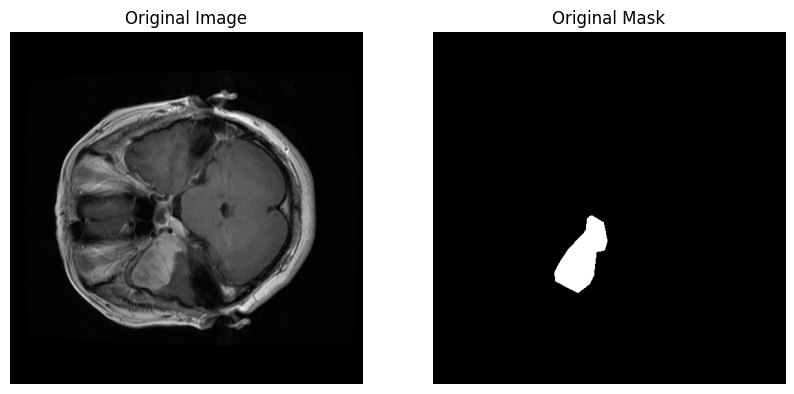

In [17]:
import albumentations as A # albumentations library used in computer vision, specifically for image augmentation

# create a transform object (optional)
transform = A.Compose([A.Resize(width=224, height=224)])

# create an instance of image segmentation custom dataset with transformations:
custom_dataset = CustomDataset(train, transform=transform)


# access first item in dataset
trans_image, trans_mask, org_image, org_mask = custom_dataset[0]

# verify transformation and normalization
print(f"original image: {org_image.shape}")
print(f"original image pixel values: min={org_image.min()}, max={org_image.max()}")
print(f"transformed image: {trans_image.shape}")
print(f"transformed image pixel values: min={trans_image.min()}, max={trans_image.max()}")

# plot original and transform images with coresponding masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(org_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(org_mask, cmap='gray')
plt.axis("off")
plt.title("Original Mask")
plt.show()

### Transform training and test datasets

In [18]:
import torch
import torchvision.transforms as T

# define the training and test data transformation using Albumentations
transform = A.Compose([A.Resize(width=224, height=224)])

train_dataset = CustomDataset(train, transform=transform)
test_dataset = CustomDataset(test, transform=transform)

In [19]:
# test the successful creation of train and test_dataset
print(len(train_dataset))
print(len(test_dataset))

500
200


### Id to label mapping

In [20]:
id2label = {0:  'bg',
            1:  'tumor'}
label2id = { label: id for id, label in id2label.items() }
n_classes = len(id2label)
n_classes

2

## 2. PyTorch DataLoders

In [46]:
from transformers import MaskFormerImageProcessor

# create a generic instance of the MaskFormerImageProcessor with specified preprocessing settings
#image_processor = MaskFormerImageProcessor(
    #ignore_index=255,       # ignore pixels with this index during processing
    #reduce_labels=False,    # the processor won't reduce the label indices to a smaller range as in multiclass segmentation
    #do_resize=False,        # already done with Albumentations
    #do_rescale=False,
    #do_normalize=False)

# load a pretrained MaskFormerImageProcessor from HuggingFace Hub, which comes with default preprocessing settings used for training
image_processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")

image_processor.ignore_index = 255
image_processor.reduce_labels = False
image_processor.do_resize = False
image_processor.do_rescale = False
image_processor.do_normalize = False

In [47]:
from torch.utils.data import DataLoader

def collate_func(batch):
  """ Collate function for DataLoader, process a single batch of data, which is a list of samples,
  where each sample contains a transformed image segmentation mask, the original image and
  the original segmentationmask. The batch is unpacked into separate list of images and
  segmentation maps, the processor is applied and returns a dictionary woth the processed
  data as tensors. The original images and segmentation masks are addedd to the processed
  batch dictionary"""

  pixel_values = [item[0] for item in batch]
  labels = [item[1] for item in batch]
  org_images = [item[2] for item in batch]
  org_masks = [item[3] for item in batch]

  # apply image processor
  inputs = image_processor(images=pixel_values, segmentation_maps=labels, return_tensors="pt")

  # add original images and masks to the processed batch
  inputs['org_images'] = torch.tensor(np.array(org_images))
  inputs['org_masks'] = torch.tensor(np.array(org_masks))

  return inputs

In [48]:
# create data loaders for training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_func, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_func, shuffle=False, num_workers=2)

print(f"Train dataloader number of samples: {len(train_dataloader.dataset)}")
print(f"Test dataloader number of samples: {len(test_dataloader.dataset)}")

Train dataloader number of samples: 500
Test dataloader number of samples: 200


### Test loading data

In [49]:
for batch_idx, batch in enumerate(test_dataloader):
  print(batch.keys())
  break

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels', 'org_images', 'org_masks'])


In [50]:
for batch_idx, batch in enumerate(train_dataloader):

  images = batch["pixel_values"]
  masks = batch["pixel_mask"]
  org_images = batch["org_images"]
  org_masks = batch["org_masks"]

  print(f"Training Batch {batch_idx}:")
  print(f"Image shape: {images.shape}")
  print(f"Mask shape: {masks.shape}")
  # training operations ...
  break # break after the first batch

# Example of iterating through the test data loader
for batch_idx, batch in enumerate(test_dataloader):

  # print(batch.keys())

  images = batch["pixel_values"]
  masks = batch["pixel_mask"]
  org_images = batch["org_images"]
  org_masks = batch["org_masks"]

  print(f"Testing Batch {batch_idx}:")
  print(f"Image shape: {images.shape}")
  print(f"Mask shape: {masks.shape}")
  # testing operations ...
  break  # break after the first batch

Training Batch 0:
Image shape: torch.Size([2, 3, 224, 224])
Mask shape: torch.Size([2, 224, 224])
Testing Batch 0:
Image shape: torch.Size([2, 3, 224, 224])
Mask shape: torch.Size([2, 224, 224])


### Convert integer to string labels

In [51]:
# access class labels for first item in batch, convert the tensor into a list, itterates
# through the list of lables and converts them into string
class_labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(class_labels)

['bg', 'tumor']


## 3. Accuracy metric

In [36]:
import evaluate

metric = evaluate.load("mean_iou")

## 4. Load, train, evaluate model

In [52]:
from transformers import MaskFormerForInstanceSegmentation

# replace pre-trained model head
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# set optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# set loss function
criterion = nn.CrossEntropyLoss()

# initialize variables for tracking running loss and the number of sample
running_loss = 0.0
num_samples = 0

### Training loop with evaluation

In [ ]:
# training loop for 2 apochs
num_epochs = 2

# initialize variables for tracking mean IoU
mean_iou_metric = 0.0
num_samples = 0

for epoch in range(num_epochs):

  # set the model to training mode
  model.train()

  print("Epoch:", epoch + 1)

  # iterate through batches in training loader
  for idx, batch in enumerate(tqdm(train_dataloader)):
    # move batch data to device and convert to float32
    pixel_values = batch["pixel_values"].to(device, dtype=torch.float32)
    mask_labels = batch["pixel_mask"].to(device)
    class_labels = [labels.to(device) for labels in batch["class_labels"]]

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values = pixel_values)
                    #mask_labels = mask_labels,
                    #class_labels = class_labels)

    # predicted class labels
    logits = outputs.class_queries_logits

    # upsample predication mask to size of true mask
    predicted = logits.argmax(dim=1)
    print(f"predicted size: {predicted.shape}")
    predicted_upsampled = nn.functional.interpolate(
          predicted[:, None, :, :].float(),  # Add a channel dimension and convert to float
          size=(224, 224),  # Target size
          mode="nearest",  # Interpolation mode
      )
    predicted_upsampled = predicted_upsampled[:, 0, :, :].long()  # Remove channel dimension and convert back to long

    # calculate the mean IoU metric for the current batch
    metric.add_batch(redictions=predicted_upsampled.detach().cpu().numpy(),
                     references=mask_labels.detach().cpu().numpy())

    # calculate loss
    loss = outputs.loss

    # accumulate loss and number of samples for the current epoch
    running_loss += loss.item() * pixel_values.size(0)
    num_samples += pixel_values.size(0)

    # backward pass and optimization
    loss.backward()
    optimizer.step()

    # print running loss every 50 batches
    if idx % 50 == 0:
      print("Loss:", running_loss / num_samples)


  # calculate the overall mean IoU for the epoch
  mean_iou_metric = metric.compute(num_labels=n_classes, ignore_index=255, reduce_labels=False)
  # print the mean IoU metric for the epoch
  print(f"Epoch {epoch+1} Mean IoU: {mean_iou_metric}")


  # evaluation loop
  model.eval() # set the model to evaluation mode

  with torch.no_grad():
    # iterate through batches in the test dataloader
    for batch in tqdm(test_dataloader):
      pixel_values = batch["pixel_values"].to(device)
      mask_labels = batch["pixel_mask"].to(device)

      # forward pass through the model
      outputs = model(pixel_values=pixel_values)

      # get predicted class labels
      logits = outputs.logits
      predicted = logits.argmax(dim=1)

      # calculate the mean IoU metric for the current batch
      metric.add_batch(predictions = predicted.detach().cpu().numpy(),
                       references = mask_labels.detach().cpu().numpy())

      # update the number of samples
      num_samples += len(mask_labels)

  # calculate the overall mean IoU for the epoch
  mean_iou_metric = metric.compute(num_labels=n_classes, ignore_index=255, reduce_labels=False)

  # print the mean IoU metric for the epoch
  print(f"Epoch {epoch+1} Mean IoU: {mean_iou_metric}")



Epoch: 1


  0%|          | 0/250 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [ ]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, device, id2label, n_classes, metric):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.id2label = id2label
        self.n_classes = n_classes
        self.metric = metric

    def train_one_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        num_samples = 0

        for idx, batch in enumerate(tqdm(self.train_dataloader)):
            pixel_values = batch["pixel_values"].to(self.device)
            labels = batch["labels"].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            running_loss += loss.item() * pixel_values.size(0)
            num_samples += pixel_values.size(0)

            loss.backward()
            self.optimizer.step()

            if idx % 50 == 0:
                print("Loss:", running_loss / num_samples)

        epoch_loss = running_loss / num_samples
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
        return epoch_loss

    def evaluate(self, epoch):
        self.model.eval()
        self.metric.reset()  # reset the metric for each epoch
        num_samples = 0

        with torch.no_grad():
            for batch in tqdm(self.test_dataloader):
                pixel_values = batch["pixel_values"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(pixel_values=pixel_values)
                logits = outputs.logits
                predicted = logits.argmax(dim=1)

                self.metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
                num_samples += len(labels)

        mean_iou = self.metric.compute(num_labels=self.n_classes, ignore_index=255, reduce_labels=False)
        print(f"Epoch {epoch+1} Mean IoU: {mean_iou}")
        return mean_iou

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch(epoch)
            mean_iou = self.evaluate(epoch)

# Instantiate the Trainer
trainer = Trainer(model, train_dataloader, test_dataloader, criterion, optimizer, device, id2label, n_classes, metric)

# Train the model
trainer.train(num_epochs=2)

## 5. Inference